In [ ]:
!pip install sklearn_crfsuite

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import nltk
import os
import re
import string
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from collections import defaultdict
from pickle import dump, load

In [2]:
Drugs = ['ARTHROTEC', 'CAMBIA', 'CATAFLAM', 'DICLOFENAC-POTASSIUM', 'DICLOFENAC-SODIUM',
         'FLECTOR', 'LIPITOR', 'PENNSAID', 'SOLARAZE', 'VOLTAREN', 'VOLTAREN-XR', 'ZIPSOR']

CLR = ['indigo', 'plum', 'darkmagenta', 'pink', 'darksalmon']

Tables = Path('E:/TM/Final/CADEC/original').glob('*.ann')

# EDA

Take a look at patient 1 who takes Arthrotec.

In [47]:
# all detected entities
pd.read_csv("E:\TM\Final\CADEC\original\ARTHROTEC.1.ann", sep='\t', header=None)

,0,1,2
0,T1,ADR 9 19,bit drowsy
1,#1,AnnotatorNotes T1,Drowsy
2,T2,ADR 29 50,little blurred vision
3,#2,AnnotatorNotes T2,Blurred Vision
4,T3,Drug 93 102,Arthrotec
5,T5,Disease 179 188,arthritis
6,T6,Symptom 260 265,agony
7,T4,ADR 62 78,gastric problems
8,T7,Symptom 412 417,pains
9,T8,ADR 437 453,feel a bit weird


In [48]:
# terms tagged with ADR that are mapped to MedDRA database
pd.read_csv("E:\TM\Final\CADEC\meddra\ARTHROTEC.1.ann", sep='\t', header=None)

,0,1,2
0,TT1,10013649 9 19,bit drowsy
1,TT2,10005886 29 50,little blurred vision
2,TT4,10056819 62 78,gastric problems
3,TT8,10025482 437 453,feel a bit weird


In [49]:
# Non-drug terms mapped to SCT database
pd.read_csv("E:\TM\Final\CADEC\sct\ARTHROTEC.1.ann", sep='\t', header=None)

,0,1,2
0,TT1,271782001 | Drowsy | 9 19,bit drowsy
1,TT2,246636008 | Blurred vision - hazy | 29 50,little blurred vision
2,TT4,162076009 | Excessive upper gastrointestinal g...,gastric problems
3,TT3,3384011000036100 | Arthrotec | 93 102,Arthrotec
4,TT5,3723001 | Arthritis | 179 188,arthritis
5,TT6,102498003 | Agony | or 76948002|Severe pain| 2...,agony
6,TT7,22253000 | Pain | 412 417,pains
7,TT8,367391008 | Malaise | 437 453,feel a bit weird


## Types of Name Entities

Not every report has name entities labelled. For those that do, there are $6$ types of name entities: **ADR, AnnotatorNotes, Disease, Drug, Finding, Symptom**. For this NER task, "AnnotatorNotes" will be removed because it is actually not a tag for the raw text but rather the controlled vocabulary that the name entity is linked to. All drugs but FLECTOR have some words in the reports tagged as ADR. The distributions of entity tags are rather different across drugs, except for VOLTAREN and VOLTAREN-XR.

In [3]:
num_Reports = dict()    # dictionary: drug --> the number of reports 
print('Number of Reports for each drug: \n')
for drug in Drugs:
    Files = Path('E:/TM/Final/CADEC/original').glob(drug+'*.ann')
    num_Reports[drug] = sum([1 for file in Files])
    print(drug, '-->', num_Reports[drug])

Number of Reports for each drug: 

ARTHROTEC --> 145
CAMBIA --> 4
CATAFLAM --> 10
DICLOFENAC-POTASSIUM --> 3
DICLOFENAC-SODIUM --> 7
FLECTOR --> 1
LIPITOR --> 1000
PENNSAID --> 4
SOLARAZE --> 3
VOLTAREN --> 68
VOLTAREN-XR --> 22
ZIPSOR --> 5


In [4]:
Tags = dict()  # a dictionary: drug --> a list of tags
Empty_tags = dict()   # a dictionary: drug --> the number of reports without any name entities labelled

for drug in Drugs:
    print(drug, ':')
    Files = Path('E:/TM/Final/CADEC/original').glob(drug+'*.ann')
    lst = list()
    count = 0
    for file in Files:
        try:
            data = pd.read_csv(file, sep='\t', header=None)
            lst.extend(data.iloc[:,1].tolist())
        except:
            st = os.stat(file)
            print(st.st_size, 'bytes <--', file)
            count += 1
    print('\n')
    Tags[drug] = lst
    Empty_tags[drug] = count

ARTHROTEC :


CAMBIA :
0 bytes <-- E:\TM\Final\CADEC\original\CAMBIA.1.ann


CATAFLAM :


DICLOFENAC-POTASSIUM :


DICLOFENAC-SODIUM :


FLECTOR :


LIPITOR :
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.197.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.243.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.28.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.285.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.299.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.308.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.313.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.383.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.4.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.40.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.41.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.416.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.437.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.438.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.444.ann
0 bytes <-- E:\TM\Fin

In [5]:
# an example of reports without any name entities labelled
fhand = open('E:/TM/Final/CADEC/text/LIPITOR.197.txt')
print(fhand.read())

None that I am aware of.
This drug has been extremely helpful to me so far.
I've been on it over a year now.
It significantly lowered my cholesterol within 3 months, which shocked me.
To be fair, I am on 3 other medications, so if I was to have any side effects I wouldn't know what to attribute it to anyway.
But so far so excellent.



In [9]:
COUNTS = {'Total Number of Reports':list(num_Reports.values()), 
          'Number of Reports without Name Entities':list(Empty_tags.values())}
pd.DataFrame(COUNTS, index=Drugs).to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &  Total Number of Reports &  Number of Reports without Name Entities \\\\\n\\midrule\nARTHROTEC            &                      145 &                                        0 \\\\\nCAMBIA               &                        4 &                                        1 \\\\\nCATAFLAM             &                       10 &                                        0 \\\\\nDICLOFENAC-POTASSIUM &                        3 &                                        0 \\\\\nDICLOFENAC-SODIUM    &                        7 &                                        0 \\\\\nFLECTOR              &                        1 &                                        0 \\\\\nLIPITOR              &                     1000 &                                       54 \\\\\nPENNSAID             &                        4 &                                        1 \\\\\nSOLARAZE             &                        3 &                                        2 \\\\\nVO

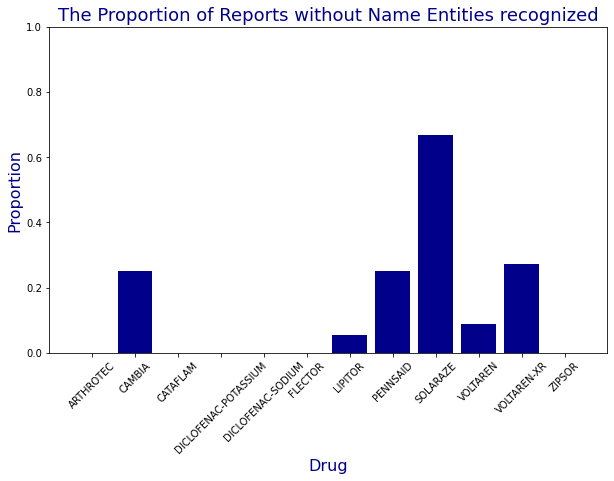

In [5]:
# the proportion of reports without any entities labelled
plt.figure(figsize=(10,6))
plt.bar(Drugs, [Empty_tags[drug]/num_Reports[drug] for drug in Drugs], color='darkblue')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.xlabel('Drug', fontsize=16, color='darkblue')
plt.ylabel('Proportion', fontsize=16, color='darkblue')
plt.title('The Proportion of Reports without Name Entities recognized', fontsize=18, color='darkblue')
plt.show()

In [6]:
# types of name entities for each drug
for drug in Drugs:
    lst = [re.findall('(\S+)\s', ele)[0] for ele in Tags[drug]]  # extract the 1st part of a tag
    lst = list(set(lst))
    lst.sort()
    print(drug, '-->', lst, '\n')

ARTHROTEC --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

CAMBIA --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding'] 

CATAFLAM --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

DICLOFENAC-POTASSIUM --> ['ADR', 'AnnotatorNotes', 'Symptom'] 

DICLOFENAC-SODIUM --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Symptom'] 

FLECTOR --> ['Disease', 'Drug', 'Symptom'] 

LIPITOR --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

PENNSAID --> ['ADR', 'AnnotatorNotes', 'Drug', 'Finding', 'Symptom'] 

SOLARAZE --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug'] 

VOLTAREN --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

VOLTAREN-XR --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

ZIPSOR --> ['ADR', 'Disease', 'Drug', 'Finding', 'Symptom'] 



Distribution of name entities across drugs: **(a)** 12 pie charts **(b)** stacked bar chart

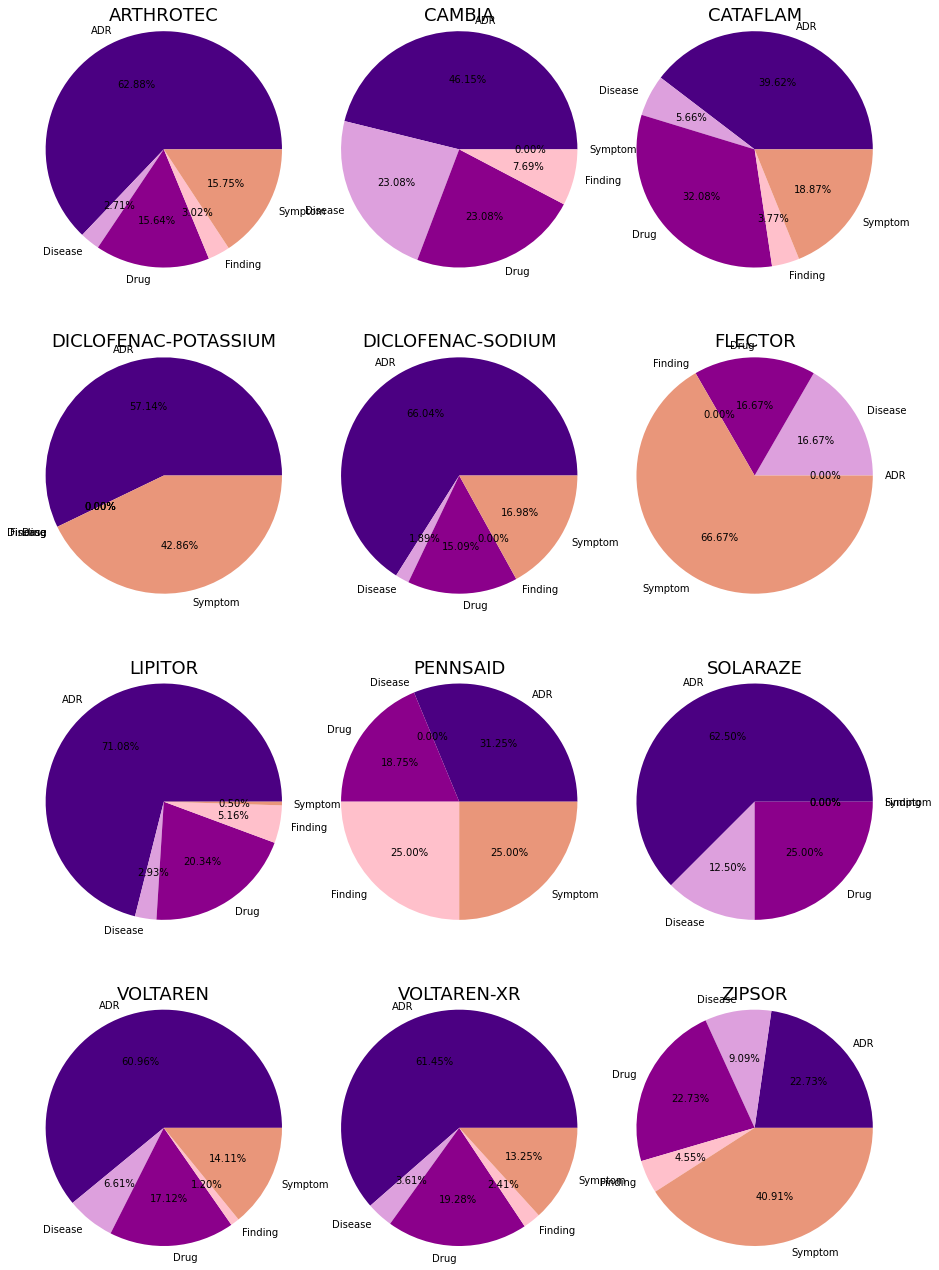

In [7]:
row,col,r = 4,3,1.2

def count_tags(raw_tags):
    Count_NE = dict()
    for entity in ['ADR', 'Disease', 'Drug', 'Finding', 'Symptom']:
        Count_NE[entity] = sum([1 for ele in raw_tags if ele.startswith(entity)])
    return Count_NE

pic,axes = plt.subplots(row,col, figsize=(15,23))
for k, drug in enumerate(Drugs):
    data =count_tags(Tags[drug])
    i = int(k/col)
    j = k - col*i
    axes[i,j].pie(list(data.values()), labels=tuple(data.keys()), autopct='%1.2f%%', colors=CLR, radius=r)
    axes[i,j].set_title(drug, fontsize=18)
plt.show()

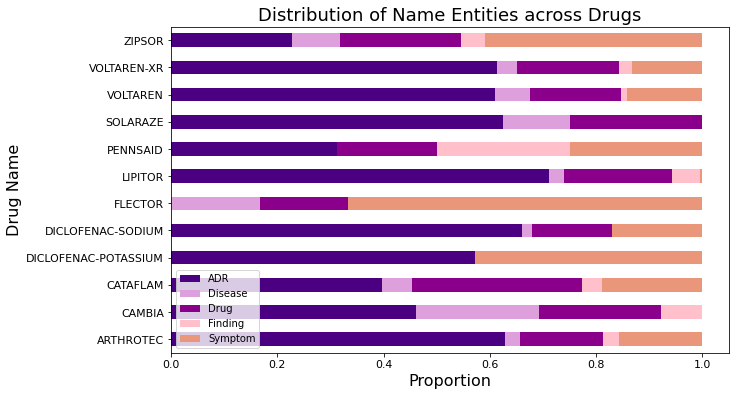

In [25]:
df = dict()
for drug in Drugs:
    df[drug] = list(count_tags(Tags[drug]).values())
df = pd.DataFrame(df, index=['ADR', 'Disease', 'Drug', 'Finding', 'Symptom']).transpose() # dataframe of tag counts across drugs
df = df.div(df.sum(axis=1), axis=0)  # normalize by rows
df['Name'] = Drugs
df.plot(x = 'Name', kind = 'barh', stacked=True, mark_right=True, figsize=(10,6), color=CLR, fontsize=11)
plt.title('Distribution of Name Entities across Drugs', fontsize=18)
plt.xlabel('Proportion', fontsize=16)
plt.ylabel('Drug Name', fontsize=16)
plt.legend(loc='lower left')
plt.show()

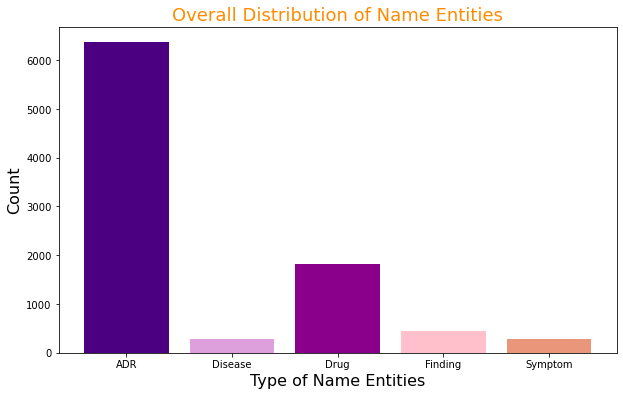

In [8]:
# overall distribution of name entities regardless of drug
plt.figure(figsize=(10,6))
plt.bar(['ADR', 'Disease', 'Drug', 'Finding', 'Symptom'],
        count_tags([ele for sublist in Tags.values() for ele in sublist]).values(),
        color = CLR)
plt.xlabel('Type of Name Entities', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Overall Distribution of Name Entities', fontsize=18, color='darkorange')
plt.show()

# Adverse Drug Effect (ADR tags)

In [31]:
# the number of raw tags for each drug
for drug in Drugs:
    print(drug, ":", len(Tags[drug]))

ARTHROTEC : 1137
CAMBIA : 14
CATAFLAM : 59
DICLOFENAC-POTASSIUM : 8
DICLOFENAC-SODIUM : 56
FLECTOR : 6
LIPITOR : 8012
PENNSAID : 19
SOLARAZE : 10
VOLTAREN : 343
VOLTAREN-XR : 84
ZIPSOR : 22


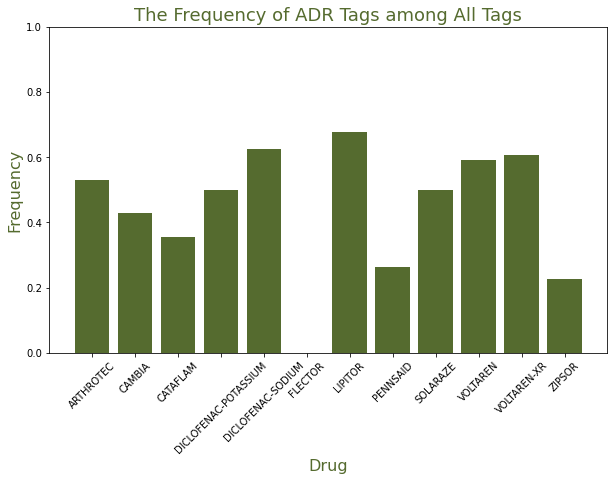

In [32]:
# frequency of ADR tags for each drug
def freq_ADR(tags):
    return sum([tag.startswith('ADR') for tag in tags]) / len(tags)

plt.figure(figsize=(10,6))
plt.bar(Drugs, [freq_ADR(Tags[drug]) for drug in Drugs], color='darkolivegreen')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.xlabel('Drug', fontsize=16, color='darkolivegreen')
plt.ylabel('Frequency', fontsize=16, color='darkolivegreen')
plt.title('The Frequency of ADR Tags among All Tags', fontsize=18, color='darkolivegreen')
plt.show()

# Pre-processing

## Representation: (token, POS, OBI)

Represent each report as a list of (token, POS, OBI).

In [3]:
# generate a list of (token,POS,OBI) tuples according to raw text and OBI lables recognized
def handle(raw_text, tags_table):
    trans_text = raw_text
    tags_table = tags_table[~tags_table.tags.str.startswith('AnnotatorNotes')]
    # process text acoording to the table
    for tag, clip in zip(tags_table.tags, tags_table.text):
        entity = re.findall('(\S+)\s', tag)[0]+'\t'
        terms = re.split('\W+', clip)
        raw_text = raw_text.replace(clip, '\t'+'\t'.join(terms)+'\t')
        trans_text = trans_text.replace(clip, '\t'+'B-'+entity + (' I-'+entity)*(len(terms)-1))
    # a list of OBI labels
    OBI = list()
    for ele in trans_text.split():
        if ele.startswith('B-') or ele.startswith('I-'):
            OBI.append(ele)
        else:
            OBI.append('O')
    # a list of (token,POS) pairs
    word_pos = nltk.pos_tag(raw_text.split())
    
    return [(token, pos, obi) for (token,pos), obi in zip(word_pos,OBI)]

In [4]:
DATA = list()

for file in Tables:
    raw_text = open('E:/TM/Final/CADEC/text/'+file.name.replace('.ann','.txt')).read()  # each report = a string
    try:
        TAB = pd.read_csv(file, sep='\t', header=None, names=['whatsoever', 'tags', 'text'])
        DATA.append(handle(raw_text, TAB))
    except:
        word_pos = nltk.pos_tag(raw_text.split())
        DATA.append([(token, pos, 'O') for token,pos in word_pos])
        
dump(DATA, open('Processed_Dataset.p', 'wb'))

In [28]:
DATA = load(open('Processed_Dataset.p', 'rb'))

print('There are', len(DATA), 'reports in total. One instance: \n')
# an example of report representation
DATA[99]

There are 1250 reports in total. One instance: 



[('Disorentatation', 'NN', 'B-ADR'),
 (',', ',', 'O'),
 ('trouble', 'NN', 'B-ADR'),
 ('brathing', 'NN', 'I-ADR'),
 (',', ',', 'O'),
 ('extreme', 'JJ', 'B-ADR'),
 ('hot', 'JJ', 'I-ADR'),
 (',', ',', 'O'),
 ('redness', 'JJ', 'B-ADR'),
 ('and', 'CC', 'I-ADR'),
 ('swelling', 'VBG', 'I-ADR'),
 (',', ',', 'O'),
 ('itching', 'VBG', 'B-ADR'),
 (',', ',', 'O'),
 ('later', 'RB', 'O'),
 ('abominal', 'JJ', 'B-ADR'),
 ('cramps', 'NNS', 'I-ADR'),
 ('.', '.', 'O'),
 ('All', 'PDT', 'O'),
 ('this', 'DT', 'O'),
 ('came', 'VBD', 'O'),
 ('all', 'DT', 'O'),
 ('sudden', 'JJ', 'O'),
 ('in', 'IN', 'O'),
 ('couple', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('minutes.', 'NN', 'O'),
 ('I', 'PRP', 'O'),
 ('had', 'VBD', 'O'),
 ('been', 'VBN', 'O'),
 ('taking', 'VBG', 'O'),
 ('arthrotec', 'JJ', 'B-Drug'),
 ('before', 'IN', 'O'),
 ('for', 'IN', 'O'),
 ('my', 'PRP$', 'O'),
 ('knee', 'NN', 'B-Symptom'),
 ('pain', 'NN', 'I-Symptom'),
 ('and', 'CC', 'O'),
 ('it', 'PRP', 'O'),
 ('helped', 'VBD', 'O'),
 ('me', 'PRP', 'O'),
 ('a',

## Split: Training Set, Development Set, Test Set

Split dataset into training set, development set, and test set by $0.6:0.2:0.2$.

In [5]:
random.seed(888)

TRAIN = random.sample(DATA, int(len(DATA)*0.6))
DEV = random.sample([report for report in DATA if not report in TRAIN], int(len(DATA)*0.2))
TEST = [report for report in DATA if not (report in TRAIN or report in DEV)]

print('There are', len(TRAIN), 'reports in the training set,', 
      len(DEV), 'in the development set, and', len(TEST), 'in the test set.')

There are 750 reports in the training set, 250 in the development set, and 250 in the test set.


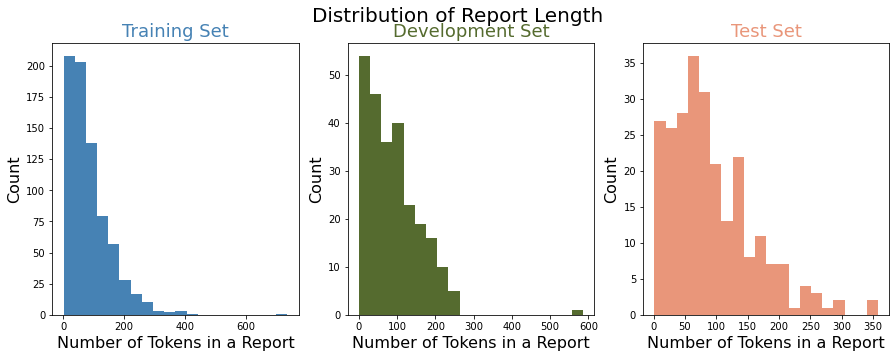

In [44]:
# distribution of report length across datsets
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Distribution of Report Length", fontsize=20)
for i,(S,C,T) in enumerate(zip([TRAIN, DEV, TEST],
                               ["steelblue","darkolivegreen","darksalmon"],
                               ["Training Set","Development Set","Test Set"])):
    axs[i].hist([len(s) for s in S], bins=20, color=C)
    axs[i].set_title(T, fontsize=18, color=C)
    axs[i].set_xlabel("Number of Tokens in a Report", fontsize=16)
    axs[i].set_ylabel("Count", fontsize=16)
plt.show()

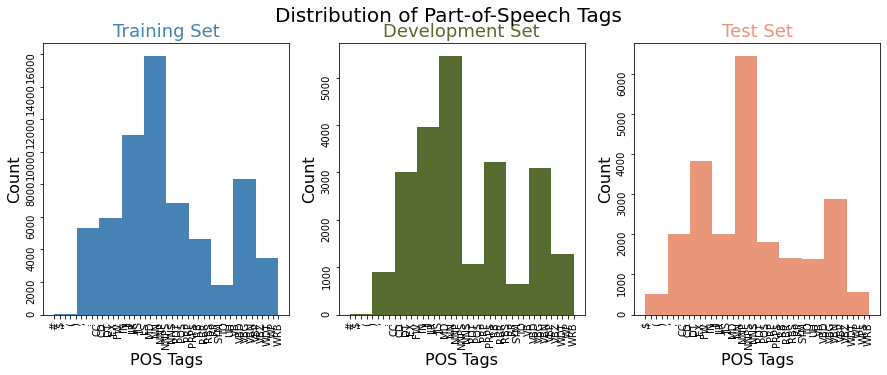

In [48]:
# distribution of POS tags
fg, ax = plt.subplots(1,3, figsize=(15,5))
fg.suptitle("Distribution of Part-of-Speech Tags", fontsize=20)
for i,(S,C,T) in enumerate(zip([TRAIN, DEV, TEST],
                               ["steelblue","darkolivegreen","darksalmon"],
                               ["Training Set","Development Set","Test Set"])):
    lst = [pos for token,pos,obi in [ele for sublist in S for ele in sublist]]
    lst.sort()
    ax[i].hist(lst, color=C)
    ax[i].set_title(T, fontsize=18, color=C)
    ax[i].set_xlabel("POS Tags", fontsize=16)
    ax[i].set_ylabel("Count", fontsize=16)
    ax[i].tick_params(labelrotation=90)
plt.show()

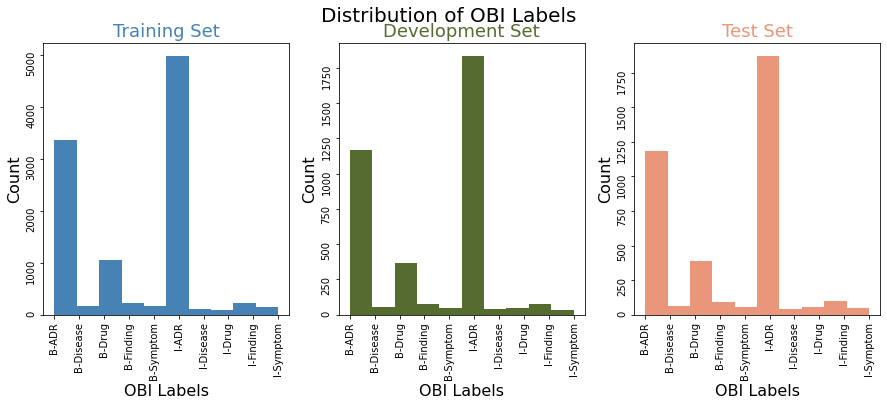

In [13]:
# distribution of name entities
pic, az = plt.subplots(1,3, figsize=(15,5))
pic.suptitle("Distribution of OBI Labels", fontsize=20)
for i,(S,C,T) in enumerate(zip([TRAIN, DEV, TEST],
                               ["steelblue","darkolivegreen","darksalmon"],
                               ["Training Set","Development Set","Test Set"])):
    lst = [obi for token,pos,obi in [ele for sublist in S for ele in sublist]]  # all OBI labels
    lst = [ele for ele in lst if not ele=='O']   # exclude O-labels
    lst.sort()
    az[i].hist(lst, color=C)
    az[i].set_title(T, fontsize=18, color=C)
    az[i].set_xlabel("OBI Labels", fontsize=16)
    az[i].set_ylabel("Count", fontsize=16)
    az[i].tick_params(labelrotation=90)
plt.show()

## Features Extraction

**Features:**
1. **Word Identity**: lowercased form
2. **Word Suffix**: the last two and three characters
3. **Word Shape**: whether a word is a digit, is uppercased, or starts with an uppercase character
4. **POS Tag**: noun, verb, adjective, e.t.c
5. **BOS**: whether a word is the beginning of sentence; if not, extract features of the previous word
6. **EOS**: whether a word is the end of sentence; if not, extract features of the following word

In [14]:
# extract features and labels
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {'bias': 1.0,
                'word.lower()': word.lower(),      # word identity
                'word[-3:]': word[-3:],            # word suffix
                'word[-2:]': word[-2:],
                'word.isupper()': word.isupper(),  # word shape
                'word.istitle()': word.istitle(),
                'word.isdigit()': word.isdigit(),
                'postag': postag,                  # POS tag  
                'postag[:2]': postag[:2],
               } 
    if i > 0:
        features['BOS'] = False
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({'-1:word.lower()': word1.lower(),          # features of the previous word
                         '-1:word.istitle()': word1.istitle(),
                         '-1:word.isupper()': word1.isupper(),
                         '-1:postag': postag1,
                         '-1:postag[:2]': postag1[:2],
                        })
    else:
        features['BOS'] = True                    # BOS
        features.update({'-1:word.lower()': 0,
                         '-1:word.istitle()': 0,
                         '-1:word.isupper()': 0,
                         '-1:postag': 0,
                         '-1:postag[:2]': 0,
                        })
        
    if i < len(sent)-1:
        features['EOS'] = False
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({'+1:word.lower()': word1.lower(),       # features of the following word 
                         '+1:word.istitle()': word1.istitle(),
                         '+1:word.isupper()': word1.isupper(),
                         '+1:postag': postag1,
                         '+1:postag[:2]': postag1[:2],
                       })
    else:
        features['EOS'] = True                   # EOS
        features.update({'+1:word.lower()': 0,
                         '+1:word.istitle()': 0,
                         '+1:word.isupper()': 0,
                         '+1:postag': 0,
                         '+1:postag[:2]': 0,
                       })
    
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [15]:
def setup(data_sents):
    return [sent2features(s) for s in data_sents], [sent2labels(s) for s in data_sents]

# set up datasets
X_train,y_train = setup(TRAIN)
X_test, y_test  = setup(TEST)
X_dev,  y_dev   = setup(DEV)

# Conditional Random Field



## Baseline

Generate **transition features** that associate all of the possible label pairs and **iterate 100 times at most** by the **L-BFGS algorithm of Gradient Descent** with Elastic-Net regularization to fit model parameters; in specific, **L1-regularization** is controlled by $c_1 = 0.1$ and **L2-regularization** by $c_2 = 0.1$.

In [16]:
# training
baseline = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
baseline.fit(X_train, y_train)

# evaluate
print('Overall Accuracy on Test Set:', baseline.score(X_test, y_test), '\n')
labels = list(baseline.classes_)
labels.remove('O')
sorted_labels = sorted(labels, key = lambda name:(name[1:], name[0]))
print(metrics.flat_classification_report(y_test, baseline.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.9077797202797203 

              precision    recall  f1-score   support

       B-ADR     0.6765    0.6216    0.6479      1184
       I-ADR     0.7220    0.6209    0.6676      1870
   B-Disease     0.5833    0.2154    0.3146        65
   I-Disease     0.5000    0.1778    0.2623        45
      B-Drug     0.8815    0.7781    0.8266       392
      I-Drug     0.8421    0.2857    0.4267        56
   B-Finding     0.2400    0.1319    0.1702        91
   I-Finding     0.1463    0.0612    0.0863        98
   B-Symptom     0.5714    0.1509    0.2388        53
   I-Symptom     0.1667    0.0638    0.0923        47

   micro avg     0.7038    0.5816    0.6369      3901
   macro avg     0.5330    0.3107    0.3733      3901
weighted avg     0.6866    0.5816    0.6246      3901



d:\python\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-ADR', 'I-ADR', 'B-Disease', 'I-Disease', 'B-Drug', 'I-Drug', 'B-Finding', 'I-Finding', 'B-Symptom', 'I-Symptom'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


## Hyperparameter Optimization on Development Set

Execute a $10 \times 10$ rough grid search on $(c_1, c_2) \in [0, 1] \times [0, 1]$ and use the development set for evaluation. Based on the results, search $[0.1, 0.3] \times [0.1, 0.3]$ more carefully. Eventually settle on **BFGS algorithm** with L1-regularization controlled by $c_1 = 0.2111$ and L2-regularization by $c_2 = 0.1667$, not using feature transitions. Its robustness is tested by cross-validation.

In [56]:

def score(c1, c2, algorithm, transitions):
    if algorithm=='lbfgs':
        crf = CRF(algorithm='lbfgs', c1=c1, c2=c2, max_iterations=100, all_possible_transitions=transitions)
    if algorithm=='l2sgd':
        crf = CRF(algorithm='l2sgd', c2=c2, max_iterations=100, all_possible_transitions=transitions)
    crf.fit(X_train, y_train)
    return metrics.flat_f1_score(y_dev, crf.predict(X_dev), average='weighted', labels=sorted_labels)

In [13]:
a,b, c,d, k = 0,1, 0,1, 10

LB = dict()
for c1 in np.linspace(a,b,k):
    lst = list()
    for c2 in np.linspace(a,b,k):
        panda = np.mean([score(c1, c2, 'lbfgs', True) for run in range(3)])
        grizzly=np.mean([score(c1, c2, 'lbfgs', False) for run in range(3)])
        lst.append((panda,grizzly))
    LB['c1 = '+str(round(c1,2))] = lst
LB = pd.DataFrame(LB, index=['c2 = '+str(round(ele,2)) for ele in np.linspace(a,b,k)])

L2 = dict()
for c2 in np.linspace(c,d,k):
    panda = np.mean([score(0, c2, 'l2sgd', True) for run in range(5)])
    grizzly=np.mean([score(0, c2, 'l2sgd', False) for run in range(5)])
    L2['c2 = '+str(round(c2,2))] = (panda, grizzly)
L2 = pd.DataFrame(L2, index=['Transition Features', 'No Transitions'])

In [14]:
LB

,c1 = 0.0,c1 = 0.11,c1 = 0.22,c1 = 0.33,c1 = 0.44,c1 = 0.56,c1 = 0.67,c1 = 0.78,c1 = 0.89,c1 = 1.0
c2 = 0.0,"(0.6283174712839279, 0.628255416959969)","(0.6176551010204843, 0.6231546455509662)","(0.6377816080886208, 0.6307590415940855)","(0.6398295657043158, 0.6401206136285866)","(0.6409003202102717, 0.6427352491482939)","(0.6366950086630925, 0.6394893953070309)","(0.6364945882018745, 0.6372582504161102)","(0.6404083411237831, 0.6391917737769398)","(0.6375253878865977, 0.6376613899274176)","(0.6375800561231276, 0.639834243559818)"
c2 = 0.11,"(0.6354573041888678, 0.6300801293556859)","(0.6423384456477031, 0.6468511231921774)","(0.6419850887250926, 0.6494101260111221)","(0.6450201796116329, 0.6427475863470934)","(0.6443873248103932, 0.6430032347608091)","(0.6435769649833379, 0.6418434317303793)","(0.6396163604306027, 0.6412124926508611)","(0.6392466959374954, 0.6384132610062944)","(0.6351237639063554, 0.6412492552821223)","(0.6391822204924948, 0.6355297500130342)"
c2 = 0.22,"(0.6405812708729197, 0.6319453891261801)","(0.6425705668145278, 0.6486262974323341)","(0.6459180328141582, 0.6424128211275654)","(0.6438994180249921, 0.6418361027857524)","(0.6440416098172754, 0.6450089844738908)","(0.6416728272391575, 0.6395404671056202)","(0.6419724836711774, 0.6353031921988554)","(0.6401136584244035, 0.635302846300829)","(0.6346315973413993, 0.6378801091705466)","(0.6390619126704771, 0.6365312590820273)"
c2 = 0.33,"(0.6415943040108925, 0.6355369028803408)","(0.6461023409454479, 0.6437481029199174)","(0.6403353620283322, 0.6465943927141939)","(0.6383916160739557, 0.6400384551659741)","(0.6440908850963576, 0.6383233938957242)","(0.6381721060421673, 0.6407539331161235)","(0.6338714909849924, 0.6372235770309571)","(0.6412369866453355, 0.6332638947554143)","(0.6322396327970226, 0.6375457820911034)","(0.6291181782031818, 0.6351032856444718)"
c2 = 0.44,"(0.6327759859502521, 0.6411887757007049)","(0.6437767583236719, 0.6444475681287528)","(0.6409373068782919, 0.647914152860376)","(0.6401868279223639, 0.641127572430591)","(0.6393907086403995, 0.6418449425165191)","(0.6408970162301272, 0.6393611063266414)","(0.6383835582534654, 0.6349885789847688)","(0.6363267984473, 0.6298841175600662)","(0.6322143309912472, 0.6345979315603317)","(0.6283668943716259, 0.630113205498729)"
c2 = 0.56,"(0.6387972148659349, 0.6330543746563816)","(0.6436987552648443, 0.6425207788579012)","(0.6392933741896537, 0.6415823201718496)","(0.6392132838036398, 0.6371332764959697)","(0.6384053174710587, 0.6399053056295871)","(0.6372964384378539, 0.6376703309524833)","(0.6393302359465279, 0.6299269921058683)","(0.6345829870704754, 0.6324897953853109)","(0.6271724037436486, 0.6269765040991333)","(0.6248496958601788, 0.6304437848964002)"
c2 = 0.67,"(0.6384689562664293, 0.6294634925188011)","(0.6408094222988374, 0.6427918862869836)","(0.6419625650010047, 0.6409847202931938)","(0.6421462777218994, 0.6376025046573022)","(0.6379184839970263, 0.6353695871387943)","(0.6324841177789137, 0.6288939684987552)","(0.6305722300165489, 0.6340249796517982)","(0.630815045583949, 0.6322930937790019)","(0.6250788031776036, 0.6325380672399362)","(0.6263171160455684, 0.6256711043624243)"
c2 = 0.78,"(0.6327624491319899, 0.6435283308680685)","(0.639922394119117, 0.6399618505837114)","(0.6436909753767452, 0.6417822774483849)","(0.6382205770210652, 0.6385183436187135)","(0.6340192424172401, 0.6361099708982964)","(0.6303125794941816, 0.634556542232367)","(0.6280715021045741, 0.629763972774911)","(0.6262757382127212, 0.6250366378913312)","(0.624632835922465, 0.6249448317343937)","(0.6229365034976677, 0.6270278388686739)"
c2 = 0.89,"(0.6353757850983068, 0.6407154961459748)","(0.6422457169141249, 0.6420805957954223)","(0.6424183290242929, 0.6338691577740367)","(0.6345370674657344, 0.6305476870199577)","(0.6297222792086793, 0.6290389423459196)","(0.6283861878925872, 0.6326202828763805)","(0.626362126554406, 0.6261285712253638)","(0.6267819637358236, 0.6224816436104422)","(0.6240771841670887, 0.6306952781976054)",

In [15]:
L2

,c2 = 0.0,c2 = 0.11,c2 = 0.22,c2 = 0.33,c2 = 0.44,c2 = 0.56,c2 = 0.67,c2 = 0.78,c2 = 0.89,c2 = 1.0
Transition Features,0.030619,0.645670,0.637738,0.624037,0.637044,0.632193,0.628554,0.639524,0.63588,0.635024
No Transitions,0.030619,0.628305,0.640980,0.627062,0.633336,0.645080,0.632358,0.637420,0.63187,0.631524


In [16]:
a,b,k = 0.1, 0.3, 10
LB_refined = dict()
for c1 in np.linspace(a,b,k):
    lst = list()
    for c2 in np.linspace(a,b,k):
        panda = np.mean([score(c1, c2, 'lbfgs', True) for run in range(3)])
        grizzly=np.mean([score(c1, c2, 'lbfgs', False) for run in range(3)])
        lst.append((panda,grizzly))
    LB_refined['c1 = '+str(round(c1,2))] = lst
LB_refined= pd.DataFrame(LB_refined, index=['c2 = '+str(round(ele,2)) for ele in np.linspace(a,b,k)])

In [17]:
LB_refined

,c1 = 0.1,c1 = 0.12,c1 = 0.14,c1 = 0.17,c1 = 0.19,c1 = 0.21,c1 = 0.23,c1 = 0.26,c1 = 0.28,c1 = 0.3
c2 = 0.1,"(0.6464638098742312, 0.6443386646923824)","(0.6454172072922202, 0.6497518902913056)","(0.6435937430308604, 0.6486400931591134)","(0.6463353450015126, 0.6457952356298277)","(0.6470903517852334, 0.6466188937242057)","(0.6507658383768214, 0.6425900745363455)","(0.6465189875616826, 0.6488735101351278)","(0.6478520325928826, 0.6415667417841711)","(0.6455598003359971, 0.6509383730858366)","(0.6425723772722977, 0.6447077110784833)"
c2 = 0.12,"(0.6443538821560084, 0.6450272831347272)","(0.6431887395361673, 0.6445603021803387)","(0.6444322259865325, 0.647005291032087)","(0.6452937496344131, 0.6485757014357574)","(0.6478001040179429, 0.6499798188052172)","(0.650797493970821, 0.6502974155099237)","(0.6463443734200423, 0.6455904923416549)","(0.646369064551881, 0.6476372887804073)","(0.6457850576697707, 0.6463729953339032)","(0.6459084873516753, 0.6407590673745596)"
c2 = 0.14,"(0.6464448267968034, 0.6486227292688196)","(0.6455025767169643, 0.6452714752081107)","(0.6476621613755865, 0.648193984746811)","(0.6453493157777176, 0.6465537564559667)","(0.6450715787106831, 0.6462747489683183)","(0.6495717463102639, 0.6458825005189748)","(0.645146864202293, 0.651562772864761)","(0.6423322156523, 0.6469285303860732)","(0.6444169153902095, 0.6480527933486702)","(0.6456314065713795, 0.647642769077534)"
c2 = 0.17,"(0.6448601494804916, 0.6477494389188119)","(0.6493101613021323, 0.6510481713899169)","(0.6472972068474615, 0.6463226209117703)","(0.6440435172628769, 0.644032172239528)","(0.6434844778209103, 0.6430936297147306)","(0.6496306761713296, 0.6507889256402121)","(0.6496483611722765, 0.6473780854359887)","(0.6451366836434971, 0.6454291302036429)","(0.6444785058078447, 0.6428534390590994)","(0.6438144156074699, 0.6438344456928705)"
c2 = 0.19,"(0.6475101888472639, 0.6484233078633634)","(0.6454966141427919, 0.6426228072590837)","(0.645391677068795, 0.650423779092599)","(0.6479860318715919, 0.650016841642942)","(0.6435652351885074, 0.6453156451473896)","(0.6468455199026253, 0.6427041853261998)","(0.6434392246940263, 0.6474528006827247)","(0.6427765357958772, 0.6458606449713512)","(0.6444106274072489, 0.6436517145319443)","(0.64803806345827, 0.6477904083030369)"
c2 = 0.21,"(0.6452391239712436, 0.6476183863699972)","(0.6464369838221202, 0.6506992271594297)","(0.6434911730281168, 0.643874771252233)","(0.6455036641428784, 0.6448586162871257)","(0.6472421031222223, 0.6440074630160101)","(0.642706414299188, 0.6458640137908309)","(0.6434291503224623, 0.6446557434725372)","(0.6452229744614781, 0.6459580798828474)","(0.6407318765760417, 0.6491417889423176)","(0.6433052276039681, 0.6410284355343061)"
c2 = 0.23,"(0.6473494587792981, 0.6426450941823924)","(0.6431982976663516, 0.6457447365882762)","(0.6446715617436255, 0.646517262768619)","(0.6445626870098575, 0.6428694810158196)","(0.644547895591003, 0.6396272898083885)","(0.6380100235183785, 0.6482205835944875)","(0.6466208868014817, 0.6458558796941718)","(0.6443086173236607, 0.6488720978615075)","(0.6442045253933741, 0.6387865307162566)","(0.6439569744939702, 0.6453861655699327)"
c2 = 0.26,"(0.6415124138541258, 0.644087319898126)","(0.6460893381267105, 0.6511880856899833)","(0.6497436721742932, 0.6442263289108391)","(0.6453308882189591, 0.6427950762430426)","(0.6474288556582719, 0.6450366143312183)","(0.6444325837566035, 0.6400552692935153)","(0.6403171894190649, 0.6432791788366656)","(0.6442213295615453, 0.6514602162362714)","(0.647862216818617, 0.6450914287495371)","(0.6448131347983896, 0.6461150027135308)"
c2 = 0.28,"(0.6439106641324751, 0.6424180303613386)","(0.6440309795937738, 0.6462211411602734)","(0.6466782508381224, 0.6392181729845992)","(0.6471104151237491, 0.6466140307978592)","(0.6455214525456532, 0.6410074562262632)","(0.6440903636792591, 0.6469070740780791)","(0.6495262336248157, 0.64424686742907)","(0.6440197981531198, 0.6401462025105238)","(0.6419200117172253, 0.6454407390269683)","(0.64651

In [20]:
crf = CRF(algorithm='lbfgs', c1=0.1+1/9, c2=0.1+0.2/9, max_iterations=1000, all_possible_transitions=False)
crf.fit(X_train, y_train)
print('Overall Accuracy on Test Set:', crf.score(X_test, y_test), '\n')
print(metrics.flat_classification_report(y_test, crf.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.9087849650349651 



d:\python\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-ADR', 'I-ADR', 'B-Disease', 'I-Disease', 'B-Drug', 'I-Drug', 'B-Finding', 'I-Finding', 'B-Symptom', 'I-Symptom'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

       B-ADR     0.6809    0.6216    0.6499      1184
       I-ADR     0.7221    0.6267    0.6711      1870
   B-Disease     0.6250    0.2308    0.3371        65
   I-Disease     0.5000    0.2222    0.3077        45
      B-Drug     0.8771    0.7832    0.8275       392
      I-Drug     0.8000    0.2857    0.4211        56
   B-Finding     0.2667    0.1319    0.1765        91
   I-Finding     0.1667    0.0612    0.0896        98
   B-Symptom     0.5385    0.1321    0.2121        53
   I-Symptom     0.0000    0.0000    0.0000        47

   micro avg     0.7073    0.5847    0.6402      3901
   macro avg     0.5177    0.3095    0.3692      3901
weighted avg     0.6863    0.5847    0.6265      3901



In [ ]:
crf = CRF(algorithm='lbfgs', c1=0.1+1/9, c2=0.1+0.6/9, max_iterations=1000, all_possible_transitions=False)
crf.fit(X_train, y_train)
print('Overall Accuracy on Test Set:', crf.score(X_test, y_test), '\n')
print(metrics.flat_classification_report(y_test, crf.predict(X_test), labels=sorted_labels, digits=4))

In [22]:
crf = CRF(algorithm='lbfgs', c1=0.1+1/9, c2=0.1, max_iterations=1000, all_possible_transitions=True)
crf.fit(X_train, y_train)
print('Overall Accuracy on Test Set:', crf.score(X_test, y_test), '\n')
print(metrics.flat_classification_report(y_test, crf.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.9081730769230769 

              precision    recall  f1-score   support

       B-ADR     0.6796    0.6216    0.6493      1184
       I-ADR     0.7200    0.6203    0.6665      1870
   B-Disease     0.6087    0.2154    0.3182        65
   I-Disease     0.5000    0.1778    0.2623        45
      B-Drug     0.8778    0.7883    0.8306       392
      I-Drug     0.8000    0.2857    0.4211        56
   B-Finding     0.2766    0.1429    0.1884        91
   I-Finding     0.1944    0.0714    0.1045        98
   B-Symptom     0.5833    0.1321    0.2154        53
   I-Symptom     0.0000    0.0000    0.0000        47

   micro avg     0.7067    0.5819    0.6383      3901
   macro avg     0.5241    0.3055    0.3656      3901
weighted avg     0.6863    0.5819    0.6243      3901



## Cross-Validation

In [8]:
num_CV = 5

random.seed(666)
ID_split = dict()
pool = [i for i in range(len(X_train))]
for k in range(num_CV):
    ID_split[k] = random.sample(pool, int(len(X_train)/num_CV))
    pool = [i for i in pool if not i in ID_split[k]]
pool = [i for i in range(len(X_train))]

In [11]:
for k in range(num_CV):
    crf = CRF(algorithm='lbfgs', c1=0.1+1/9, c2=0.1+0.6/9, max_iterations=1000, all_possible_transitions=False)
    X = [X_train[ID] for ID in pool if not ID in ID_split[k]]
    y = [y_train[ID] for ID in pool if not ID in ID_split[k]]
    crf.fit(X, y)
    F1 = metrics.flat_f1_score([y_train[ID] for ID in ID_split[k]], 
                               crf.predict([X_train[ID] for ID in ID_split[k]]), 
                               average='weighted', labels=sorted_labels)
    print('k =', k, ': Weighted Average F1 score =', F1, '\n')

k = 0 : Weighted Average F1 score = 0.6544989969839232 

k = 1 : Weighted Average F1 score = 0.6720002701820069 

k = 2 : Weighted Average F1 score = 0.6721282343441461 

k = 3 : Weighted Average F1 score = 0.6274910022854813 

k = 4 : Weighted Average F1 score = 0.6557892458858025 



# Decision Tree & Random Forest

Decision Tree and Random Forest classifiers perform significantly worse than CRF, so we skip hyperparameters tuning. Although cross-validation suggests that they're both robust classifiers.

In [12]:
def trans(X,y):
    
    # transform X (features) to a dataframe: column = feature (converted to numeric), row = token
    all_in_list = [ele for sublist in X for ele in sublist]  # a list of dictionaries, each describing a token
    DF = dict()
    for i,token in enumerate(all_in_list):
        DF[i] = list(token.values())
    DF = pd.DataFrame(DF, index=all_in_list[0].keys()).transpose()  # a dataframe of strings, Boolean, and numeric
    cat_cols = DF.select_dtypes(include='object').columns
    D = defaultdict(preprocessing.LabelEncoder)
    DF[cat_cols] = DF[cat_cols].apply(lambda x: D[x.name].fit_transform(x.astype(str))) # a dataframe of numerically encoded features
    
    # transform y (labels) to a dataframe: column = OBI, row=token
    OBI = {'OBI':[ele for sublist in y for ele in sublist]}     
    OBI = pd.DataFrame(OBI, index=[i for i in range(len(all_in_list))])
    
    return DF, OBI


# transform datasets into proper format for Decision Trees
X_TRAIN,y_TRAIN = trans(X_train,y_train)
X_DEV,  y_DEV   = trans(X_dev,  y_dev)
X_TEST, y_TEST  = trans(X_test, y_test)

In [13]:
DT = DecisionTreeClassifier()
DT.fit(X_TRAIN, y_TRAIN)
print(classification_report(y_TEST, DT.predict(X_TEST), labels=sorted_labels, digits=4))

              precision    recall  f1-score   support

       B-ADR     0.1616    0.1495    0.1553      1184
       I-ADR     0.1363    0.1016    0.1164      1870
   B-Disease     0.0113    0.0308    0.0165        65
   I-Disease     0.0101    0.0222    0.0139        45
      B-Drug     0.0370    0.0638    0.0469       392
      I-Drug     0.0000    0.0000    0.0000        56
   B-Finding     0.0175    0.0110    0.0135        91
   I-Finding     0.0000    0.0000    0.0000        98
   B-Symptom     0.0455    0.0189    0.0267        53
   I-Symptom     0.0040    0.0213    0.0068        47

   micro avg     0.1044    0.1020    0.1032      3901
   macro avg     0.0423    0.0419    0.0396      3901
weighted avg     0.1195    0.1020    0.1089      3901



In [15]:
RF = RandomForestClassifier(criterion='entropy')
RF.fit(X_TRAIN, y_TRAIN)
print(classification_report(y_TEST, RF.predict(X_TEST), labels=sorted_labels, digits=4))

<ipython-input-15-d76a49afa3b0>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_TRAIN, y_TRAIN)
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ADR     0.4440    0.0971    0.1594      1184
       I-ADR     0.5453    0.1898    0.2816      1870
   B-Disease     0.0000    0.0000    0.0000        65
   I-Disease     0.0000    0.0000    0.0000        45
      B-Drug     0.3000    0.0689    0.1120       392
      I-Drug     0.0000    0.0000    0.0000        56
   B-Finding     0.0000    0.0000    0.0000        91
   I-Finding     0.0000    0.0000    0.0000        98
   B-Symptom     0.0000    0.0000    0.0000        53
   I-Symptom     0.0000    0.0000    0.0000        47

   micro avg     0.4970    0.1274    0.2028      3901
   macro avg     0.1289    0.0356    0.0553      3901
weighted avg     0.4263    0.1274    0.1946      3901



## Cross-Validation

In [21]:

rf = RandomForestClassifier(criterion='entropy')
cross_val_score(rf, X_TRAIN, y_TRAIN, scoring=make_scorer(f1_score, average='weighted', labels=sorted_labels), cv=5)

d:\python\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\python\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\python\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\python\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

array([0.50733432, 0.53763007, 0.49425022, 0.5287254 , 0.54564118])

# BioBERT